# Cosmology (Phys 212) Final Project

In the following notebook, we analize an expansion to the $\Lambda$-CDM model of cosmology which includes massive neutrinos and (at least one) sterile neutrino. Throughout the notebook, comments and markdown cells will expand on what the code is doing, and why I've made the choices I've made. To practice with CLASS and emcee, and to validate some of the methods I've used here, I used the code found in my $\Lambda$-CDM notebook (also included in this github).

We perform an MCMC likelihood analysis of our expanded model on the PLANCK 2018 data (the actual assignment), where we include 3 massive neutrinos, 1 light sterile neutrino. Furthermore, inpsired by the (admittedly out-of-date) paper https://arxiv.org/pdf/astro-ph/9602135.pdf, we include a chemical potential for the sterile neutrino. We then fit three parameters to the model (fixing the others to the CLASS calculated/PLANCK best-fit values) - omega_b, omega_cdm, and h.

This notebook is composed with reference to the "CLASS" reference notebooks and this source on MCMC analysis (https://prappleizer.github.io/Tutorials/MCMC/MCMC_Tutorial.html)

Github copilot has been used to write better comments. (I'm not sure why it's doing it, but I actually can't figure out how to disable this "feature". It is not being used to write code.)

In [5]:
from classy import Class
import numpy as np
import matplotlib.pyplot as plt
import corner
import pandas as pd
import emcee
import tqdm

# Load our CMB power spectrum data.
Data has been obtained from the Planck Legacy Archive: https://pla.esac.esa.int/pla/#cosmology 

The data is the power spectrum of the CMB temperature anisotropies in terms of $D_l^{TT}$.

In [6]:

data_file = '~/physics/COM_PowerSpect_CMB-TT-full_R3.01_with_header.txt'
data = pd.read_csv(data_file, sep='\s+', comment='#')
data = data.head(2499)

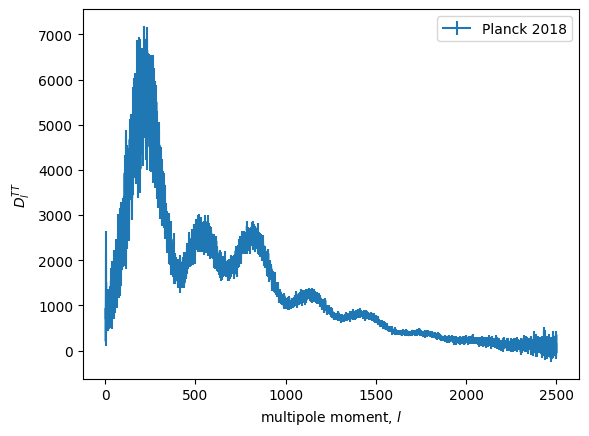

In [7]:
#Visualize the Planck 2018 data

errorbars = [data['-dDl'], data['+dDl']]
plt.errorbar(data['l'], data['Dl'], yerr = errorbars, label='Planck 2018')
plt.xlabel("multipole moment, $l$")
plt.ylabel("$D_l^{TT}$")
plt.legend()

# Define our model

Because we don't have an accessible analytical model of the CMB temperature anisotropy, we're going to use the CLASS simulator to define our model for the MCMC. 

CLASS code and documentation can be found here: https://lesgourg.github.io/class_public/class.html#documentation
The authors request the following paper be cited when the software is use in publication: https://arxiv.org/abs/1104.2933

In [22]:
# # Deprecated - couldn't support order GeV masses
# N_ur = 1.0176 # A value of 3.044 would indicate 3 massless neutrinos. We're including massive neutrinos, but including one massless neutrino here because lighter neutrino masses seem more likely (at least to me). 

# N_ncdm = 4 # Number of massive neutrinos, including sterile neutrinos

# delta_msq_21 = 7.6e-5 # Mass squared difference between the second and first neutrino mass eigenstates, in eV^2
# delta_msq_31 = 2.5e-3 # Mass squared difference between the third and first neutrino mass eigenstates, in eV^2
# # We'll assume for now the lightest neutrino is massless. We also assume the normal ordering. Values from https://www.frontiersin.org/articles/10.3389/fspas.2018.00036/full

# m_ncdm = '0.00872, 0.05, 0.5, 0.6e6'  # Masses of each of the massive neutrinos, in eV
# # We choose sterile neutrinos of 0.5 eV (the right order of magnitude active/sterile neutrino osscilations), and 0.6 GeV (one of the masses I'm considering in my dissertation research, and therefore of personal interest).

# # 5.f) 'ksi_ncdm' is the ncdm chemical potential in units of its own temperature (default: set to 0)
# ksi_ncdm = '0, 0, 0.1, 0.5' # Though out of date, this paper https://arxiv.org/pdf/astro-ph/9602135.pdf explores the interesting potential of non-zero neutrino chemical potentials (pun intended, sorry) on helping to resolve neutrino oscillation anomalies without constradicting cosmological data.

In [41]:
# Test a more standard scenario to get the code working

N_ur = 1.0176 # A value of 3.044 would indicate 3 massless neutrinos. We're including massive neutrinos, but including one massless neutrino here because lighter neutrino masses seem more likely (at least to me). 

N_ncdm = 3 # Number of massive neutrinos, including sterile neutrinos

delta_msq_21 = 7.6e-5 # Mass squared difference between the second and first neutrino mass eigenstates, in eV^2
delta_msq_31 = 2.5e-3 # Mass squared difference between the third and first neutrino mass eigenstates, in eV^2
# We'll assume for now the lightest neutrino is massless. We also assume the normal ordering. Values from https://www.frontiersin.org/articles/10.3389/fspas.2018.00036/full

m_ncdm = '0.00872, 0.05, 0.5'  # Masses of each of the massive neutrinos, in eV
# We choose a sterile neutrino of 0.5 eV (the right order of magnitude active/sterile neutrino osscilations)
# I explored the possibility of also including and HNL, but it seems like CLASS (at least as I've configured it) will only support particle masses up to the eV scale in this parameter.

# 5.f) 'ksi_ncdm' is the ncdm chemical potential in units of its own temperature (default: set to 0)
ksi_ncdm = '0, 0, 0.1' # Though out of date, this paper https://arxiv.org/pdf/astro-ph/9602135.pdf explores the interesting potential of non-zero neutrino chemical potentials (pun intended, sorry) on helping to resolve neutrino oscillation anomalies without constradicting cosmological data.

In [42]:
theta_test =  np.array([0.0223828, 0.1201075, 0.67810, np.pi*2])
get_Dls(theta_test)

array([818.64410177, 782.92400655, 747.00189988, ...,  64.61712455,
        64.44062859,  64.26310082])

In [83]:
multipole = data['l'].astype(int)
def model(theta, ells = multipole):
    '''
    Define a cosmological model we'll use to fit the PLANCK data.
    Inputs:
    theta: array of floats, model parameters
    ells: array of integers, multipole moments at which to evaluate the model (included for completion)
    Returns:
    LambdaCDM: CLASS instance, the model
    '''
    
    omega_b, omega_cdm, h, amp = theta
    #Initiate CLASS
    LambdaCDM = Class()

    # Set out (relatively exotic) model parameters (defined above):
    LambdaCDM.set({'N_ur':N_ur,'N_ncdm':N_ncdm,'m_ncdm':m_ncdm,'ksi_ncdm':ksi_ncdm})

    # pass parameters we're fitting
    LambdaCDM.set({'omega_b':omega_b,'omega_cdm':omega_cdm,'h':h})
    #Set CLASS generator settings
    LambdaCDM.set({'output':'tCl,lCl','lensing':'yes'})

    # run class - this creates our model
    LambdaCDM.compute()

    return LambdaCDM
    # get the CMB power spectrum

def get_cls(cmb_model):
    '''
    Get the CMB Temperature power spectrum from a CLASS model
    Inputs:
    cmb_model: CLASS instance, a cosmological model
    Returns:
    cls: array of floats, CMB Temperature power spectrum values
    '''
    all_cls = cmb_model.lensed_cl(2500)['tt'] #ls start at 0, so this gives cls up to l = 2500
    cls = all_cls[2:] #Our data start at l = 2
    cls_microK =cls*10**12 #Convert from K^2 to microKelvin sqaured to match Planck's units
    return cls_microK

def get_Dls(theta):
    '''
    Takes a set of cosmological parameters and returns the CMB temperature power spectrum in Dls (to match the Planck data)
    Inputs:
    theta: array of floats, model parameters
    Returns:
    Dls: array of floats, CMB temperature power spectrum values C_l*l*(l+1)/(2*pi)
    '''
    omega_b, omega_cdm, h, amp = theta
    CMB_model = model(theta)
    cls = get_cls(CMB_model)
    simulated_ls = CMB_model.lensed_cl(2500)['ell'] #ls start at 0, so this gives cls up to l = 2500
    l = simulated_ls[2:]
    Dls = amp*l*(l+1)*cls/(2*np.pi)
    return Dls

def log_likelihood(dls, x, y, yerr_up, yerr_down, amp):
    # get the model Dl for the given 'l' (passed as x). The index of each l is l-2, and l starts at 2.
    
    indeces = np.linspace(0, 2498, 2499).astype(int)
    model_y = dls[indeces]
    # calculate the likelihood
    y_err = yerr_down + yerr_up
    chi2 = np.sum((y - model_y)**2 / (y_err**2))

    ln_like = -0.5*chi2
    return ln_like

def check_priors(theta):
    # Prior ranges are inspired by the 1-sigma ranges summarized in this paper:https://www.aanda.org/articles/aa/pdf/2019/03/aa34060-18.pdf
    # I've taken the largest reported 1-sigma range for each parameter used the precision on the last digit to determine the prior (this makes them slightly assymetric in terms of amount above/below the 1 sigma interval, but I'm okay with that).
    omega_b, omega_cdm, h, amp = theta
    # LambdaCDM.set({'omega_b':0.0223828,'omega_cdm':0.1201075,'h':0.67810,'A_s':2.100549e-09,'n_s':0.9660499,'tau_reio':0.05430842})
    # if (not (omega_b/h**2 + omega_cdm/h**2) < 1):
    #     #Make sure we don't overload the total energy density
    #     return False
    if not(0.0222 < omega_b <0.0226):
        return False
    if not(0.118 < omega_cdm <0.122):
        return False
    if not(0.664 < h <0.684):
        return False
    if not (2*np.pi < amp < 3*np.pi):
        return False
    return True

def ln_prob(theta, x, y, yerr_up, yerr_down):
    omega_b, omega_cdm, h, amp = theta
    # Check if this set of parameters is allowed
    possible = check_priors(theta)
    if not possible:
        return -np.inf
    
    dls = get_Dls(theta)

    # get the likelihood
    ln_likelihood = log_likelihood(dls, x, y, yerr_up, yerr_down, amp)
    return ln_likelihood


# Set up the MCMC Sampler
This code, as well as the MCMC running function, structured absed on the MCMC tutorial cited above

In [117]:
# Set up you 'guess' for the MCMC (IE, the first theta)
theta_start = np.array([0.0224, 0.120, 0.678, np.pi*2]) #These are the values from the CLASS example, and a guess for  an amplitude conversion factor

# Set up the number of walkers and iterations for each walker
n_dim  = len(theta_start)
n_walkers = 64

# Each walker will start at a 1e-7 fluctuation from the guess, except for the amplitude parameter which has a much larger fluctuation
p0 = np.array([np.array(theta_start) + 1e-4 * np.random.randn(n_dim) for i in range(n_walkers)])
a_s = theta_start[3]
for i in range(n_walkers):
    p0[i,3] = 2.5*np.pi + 0.3*np.random.rand()

In [122]:
from multiprocessing import Pool
import cosmo_helpers as ch
def run_sampler(p0, nwalkers, niter, ndim, lnprob):
    # Define your sampler, giving it the likelihood and data

    with Pool() as pool:
        sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args = (data['l'], data['Dl'], data['+dDl'], data['-dDl']), pool=pool)
        
        # Following the argument here (http://users.stat.umn.edu/~geyer/mcmc/burn.html) which I find convincing, I'm neglecting to include a burn-in sample, and instead we're starting with points near the PLANCK best-fits as defined above.
    
        print("Running production...")
        pos, prob, state = sampler.run_mcmc(p0, niter, progress=True)

    return sampler, pos, prob, state

In [124]:
n_iterations = 275 # This number is chosen based on how many events I can get in eight hours based on test runs.

# Run the MCMC
sampler, pos, prob, state = run_sampler(p0, n_walkers,n_iterations, n_dim, ch.ln_prob)
print(prob)

# This takes about 11 minutes for 20 iterations with ten walkers, so we'll take that into account when deciding how many to run for the analysis
# 2 iterations with 100 walkers took about 13 minutes. If so, we can do about 8 iterations/hour, so we'll run 750 iterations (with a burn sample of 50) overnight.
#With parallelization, it took about 90 seconds last time
# Oh shit I was off by a factor of ten here.

Running production...


  0%|          | 0/275 [00:00<?, ?it/s]/opt/homebrew/lib/python3.11/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
100%|██████████| 275/275 [5:59:45<00:00, 78.49s/it]    

[-484.63773361 -483.29168419 -484.00289416 -482.14218684 -484.36843019
 -482.00551098 -485.44078654 -481.73470911 -484.10552389 -484.767104
 -483.98999964 -487.77166941 -482.95096208 -484.40660005 -483.1270847
 -485.07687186 -483.47501809 -483.27189544 -483.85209298 -481.52127795
 -482.15647059 -483.82690215 -483.77353169 -483.60096101 -485.35742933
 -487.28511851 -487.01680849 -483.85578959 -485.47096125 -481.99153369
 -481.41406281 -487.5977964  -485.50327864 -481.07634248 -484.63119714
 -484.58459761 -482.66168616 -483.98505299 -486.08544569 -483.00510752
 -483.01715606 -484.55548325 -484.74468547 -483.48021271 -481.89465544
 -480.79593136 -485.45829535 -482.64875997 -485.46285078 -481.2450494
 -486.50130907 -482.95847662 -485.19665231 -481.59169596 -482.96026398
 -484.4460006  -483.21323622 -483.2356721  -484.71576501 -482.35738528
 -487.10832642 -481.1158024  -481.8881403  -482.17535311]


In [127]:
# things we want to save: 
flat_samples = sampler.flatchain
flat_lnprobs = sampler.flatlnprobability
# Save the samples

df = pd.DataFrame({'omega_b': flat_samples[:,0], 
                   'omega_cdm': flat_samples[:,1], 
                   'h': flat_samples[:,2], 
                   'amp': flat_samples[:,3],
                   'lnprob': flat_lnprobs
                   })
df.to_csv('cosmo_mcmc.csv', index=False)

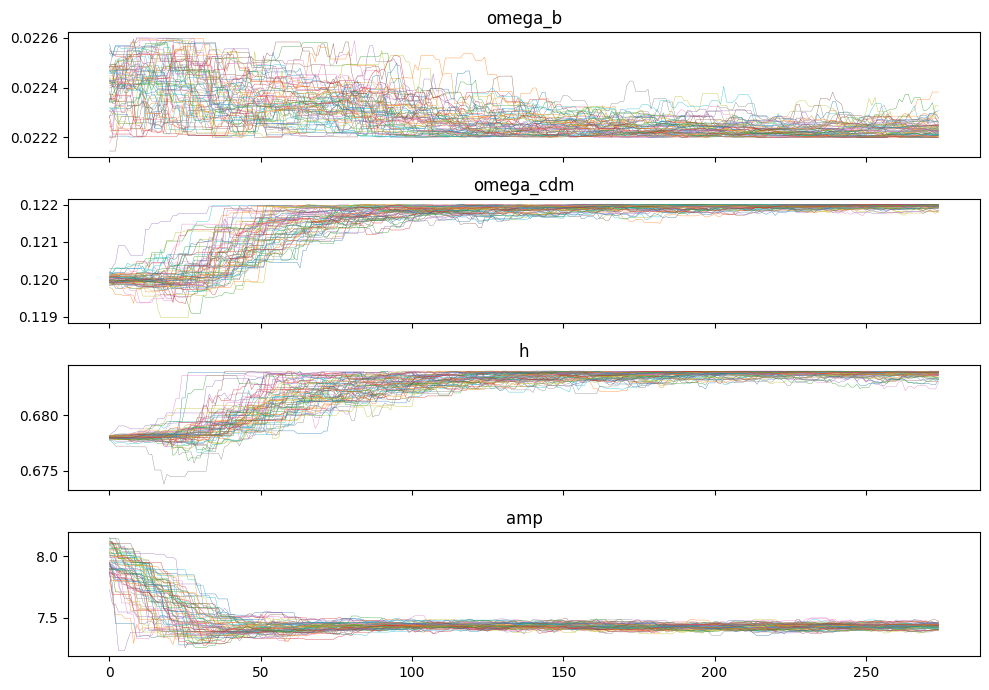

In [129]:
# make traceplots for each parameter to assess convergence - Each of our walkers is a different chain, so we can test walkers against one another.
samples = sampler.chain
n_iter = len(samples[0])

fig, (ax0, ax1, ax2, ax3) = plt.subplots(4, 1, figsize=(10, 7), sharex=True)
for walker in sampler.chain:
    ax0.plot(walker[:,0], label='omega_b', lw=0.25)
    ax1.plot(walker[:,1], label='omega_cdm', lw=0.25)
    ax2.plot(walker[:,2], label='h', lw=0.25)
    ax3.plot(walker[:,3], label='amp', lw=0.25)
ax0.set_title('omega_b')
ax1.set_title('omega_cdm')
ax2.set_title('h')
ax3.set_title('amp')
plt.tight_layout()

In [148]:
tau = sampler.get_autocorr_time()
print(tau)

AutocorrError: The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 6;
tau: [31.99536897 33.51499814 35.06662014 16.40113012]

In [159]:
# Plot you MCMC results

Dls = data['Dl']
ls = data['l']

def plotter(sampler,ls = ls, dls=Dls):
    plt.ion()
    plt.plot(ls, dls,label="$D_l^{TT}$")
    samples = sampler.flatchain
    # for n, theta in enumerate(samples[np.random.randint(len(samples), size=20)]):
    for n, theta in enumerate(samples[np.linspace(0, len(samples)-1, 64).astype(int)]):
        if (flat_lnprobs[n] > -np.inf):
            Dls = get_Dls(theta)
            plt.plot(ls, Dls, color="r", alpha=0.1)
        #If this set of parameters isn't allowed, do nothing
    plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
    plt.xlabel('l')
    plt.ylabel("$D_l^{TT}$")
    plt.legend()
    plt.show()

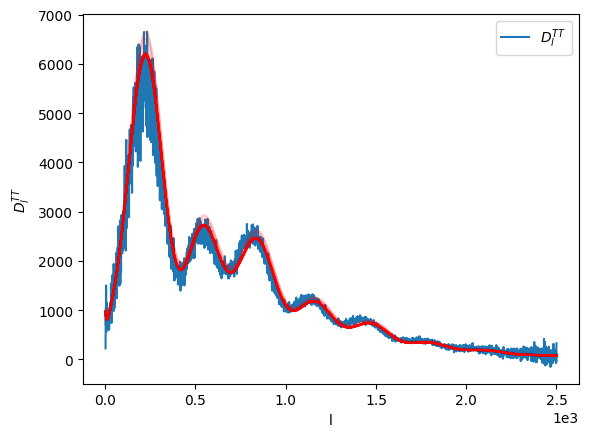

In [160]:
plotter(sampler)

In [ ]:
# Draw the posterior distributions given by the normalized histogram of the samples



Text(0, 0.5, 'lnprob')

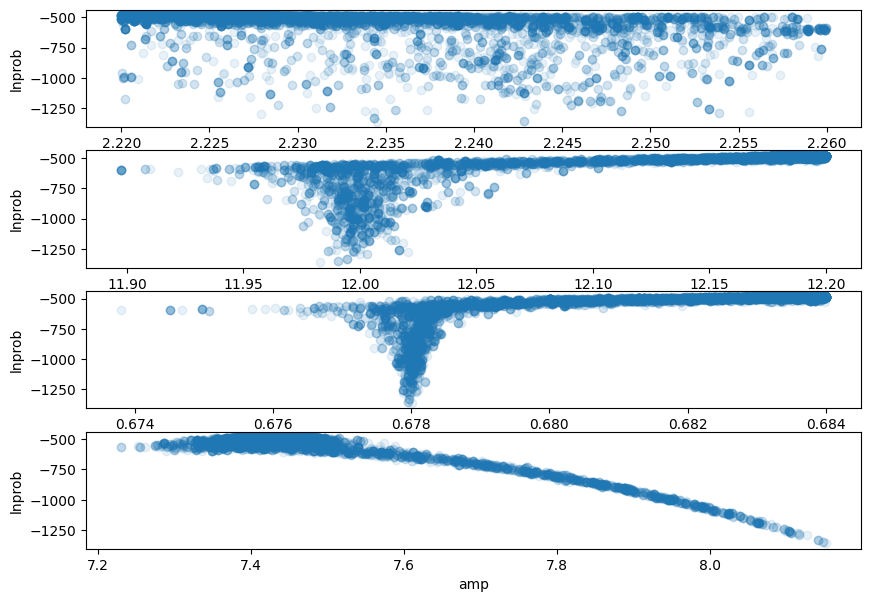

In [169]:

theta_max = flat_samples[np.argmax(flat_lnprobs)]
fig, (ax0, ax1, ax2, ax3) = plt.subplots(4, 1, figsize=(10, 7))

ax0.plot(flat_samples[:,0]*100, flat_lnprobs, 'o', alpha=0.1)
ax0.set_xlabel('omega_b (*100)')
ax0.set_ylabel('lnprob')

ax1.plot(flat_samples[:,1]*100, flat_lnprobs, 'o', alpha=0.1)   
ax1.set_xlabel('omega_cdm (*100)')
ax1.set_ylabel('lnprob')

ax2.plot(flat_samples[:,2], flat_lnprobs, 'o', alpha=0.1)  
ax2.set_xlabel('h')
ax2.set_ylabel('lnprob')

ax3.plot(flat_samples[:,3], flat_lnprobs, 'o', alpha=0.1)
ax3.set_xlabel('amp')   
ax3.set_ylabel('lnprob')


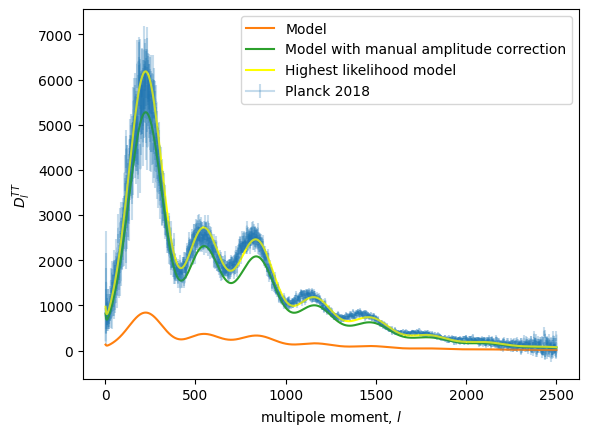

In [145]:
# Check CLASS' solution for the standard set of parameters against the PLANCK data

plt.errorbar(data['l'], data['Dl'], errorbars, label='Planck 2018', alpha=0.25)

theta_cdm = [0.0223828, 0.1201075, 0.67810, 1]

dls = get_Dls(theta_cdm)#*10**12.85# We're probably missing a unit conversion here
plt.plot(ls, dls, label='Model')

theta_cdm_amped = [0.0223828, 0.1201075, 0.67810, 2*np.pi]
dls_amped = get_Dls(theta_cdm_amped)# Add an amplitude correction here
plt.plot(ls, dls_amped, label='Model with manual amplitude correction')

dls_bf = get_Dls(theta_max)
plt.plot(ls, dls_bf, label='Highest likelihood model', color='yellow', alpha=1.)

plt.xlabel("multipole moment, $l$")
plt.ylabel("$D_l^{TT}$")
plt.legend()

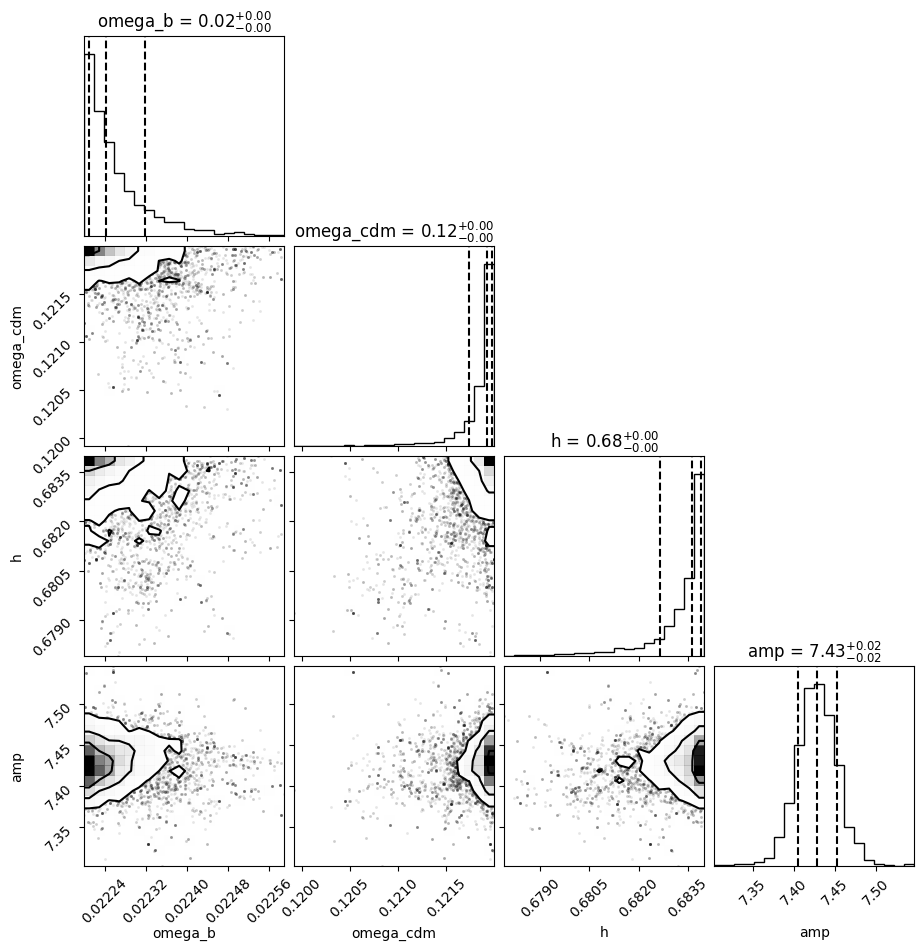

In [239]:
import corner

no_burn_samples = sampler.chain[:, 50:, :].reshape((-1, n_dim))

quantiles=[0.16, 0.5, 0.84]
labels = ['omega_b', 'omega_cdm', 'h', 'amp']
fig = corner.corner(flat_samples, show_titles=True, labels=labels, plot_datapoints = True, quantiles=quantiles)

# Analysis

We see from the above corner plot that while we may have converged around an amplitude and a value for $\Omega_bh^2$, the values for $\Omega_{CDM}h^2$ and $h_0$ simply headed for the high end of the distribution and stayed there.

This implies that our chemical-potential having sterile neutrino wants to push the dark matter density and $h_0$ well beyond what PLANCK has assessed them to be. This is unsurprising, because we've altered the behavior of dark matter overall pretty significantly here, and because this study [1] of differences in best-fit values between different neutrino models and Boltzmann solvers shows that those differences lead to non-negligible differences (beyond 1-sigma) in the preffered values of $h_0$. 

By looking at the corner plot, and our traceplots above, we know that it's unlikely that we've reached a very good fit, but we're going to perform some more formal statistical analysis on our MCMC results to be rigorous.

Additionally, I've sent another MCMC sampler with looser upper bounds on $\Omega_{CDM}$ and $h_0$. Furthermore, given that our autocorrelation time is about 35 iterations, and emcee suggests running 50*$\tau$ (in our case, about 1750) times, so I will update the number of iterations there. I will update this notebook with those results if they finish in time.

[1] _Comparison of results on Neff from various Planck likelihoods_ https://www.aanda.org/articles/aa/pdf/2019/03/aa34060-18.pdf

In [176]:
# Code for this cell adapted from the emcee documentation: https://emcee.readthedocs.io/en/stable/tutorials/line/
from IPython.display import display, Math
ndim = 4

labels = ['\Omega_b', '\Omega_{cdm}', 'h', 'Amp']

for i in range(ndim):
    mcmc = np.percentile(flat_samples[:, i], [16, 50, 84])
    q = np.diff(mcmc)
    txt = "\mathrm{{{3}}} = {0:.3f}_{{-{1:.3f}}}^{{{2:.3f}}}"
    txt = txt.format(mcmc[1], q[0], q[1], labels[i])
    display(Math(txt))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [187]:
# Let's take our best fit parameters and see how the likelihood compares to the CLASS defualt parameters
# (I'm making the assumption here that these are the best fit parameters, correcting for whatever strange amplitude effect we're seeing)
no_burn_likelihoods = sampler.lnprobability[:, 50:].reshape((-1, n_dim))

theta_max = flat_samples[np.argmax(no_burn_likelihoods)]

likelihood_max = np.max(no_burn_likelihoods)

default_params = Class()
default_params.set({'output':'tCl, lCl', 'lensing':'yes'})
default_params.compute()
ells = default_params.lensed_cl(2500)['ell'][2:]
dls_default_params = (10**12)*default_params.lensed_cl(2500)['tt'][2:]*ells*(ells+1)

ln_likelihood = log_likelihood(dls_default_params, data['l'], data['Dl'], data['-dDl'], data['+dDl'], 1)

print(f"Likelihood of best fit parameters: {likelihood_max}")
print(f"Likelihood of default parameters: {ln_likelihood}")
print (f"Ratio of likelihoods: {np.exp(likelihood_max - ln_likelihood)}")



Likelihood of best fit parameters: -480.754269235625
Likelihood of default parameters: -1922.920036845379
Ratio of likelihoods: inf


/var/folders/jt/x63wbq5x23s7bnm3x8qff6lw0000gn/T/ipykernel_54751/66160134.py:19: RuntimeWarning: overflow encountered in exp
  print (f"Ratio of likelihoods: {np.exp(likelihood_max - ln_likelihood)}")


In [222]:
# Define AIC (Akaike Information Criterion) https://en.wikipedia.org/wiki/Akaike_information_criterion

aic_best_fit = 2*10 - 2*likelihood_max # There are ten parameters in the standard cosmological model, even though we haven't fit them all directly in this analysis
aic_default = 2*10 - 2*ln_likelihood

neff_likelihood = log_likelihood(dls_neff, data['l'], data['Dl'], data['-dDl'], data['+dDl'], 1)
aic_neff = 2*10 - 2*neff_likelihood

relative_likelihood = np.exp((aic_best_fit - aic_default)/2)

relative_likelihood2 = np.exp((aic_best_fit - aic_neff)/2)

print(f"The relative likelihood of the default CLASS model to our best-fit is {relative_likelihood}")

print(f"The relative likelihood of the default CLASS model with higher Neff to our best-fit is {relative_likelihood2}")


The relative likelihood of the default CLASS model to our best-fit is 0.0
The relative likelihood of the default CLASS model with higher Neff to our best-fit is 0.0


Though not entirely inexpected (by which I mean, entirely expected), it's a bit dissapointing to find our model is completely disfavored compared to the baseline.

In [227]:
print(np.exp(-neff_likelihood + likelihood_max))
print(likelihood_max)

inf
-480.754269235625


/var/folders/jt/x63wbq5x23s7bnm3x8qff6lw0000gn/T/ipykernel_54751/405821859.py:1: RuntimeWarning: overflow encountered in exp
  print(np.exp(-neff_likelihood + likelihood_max))


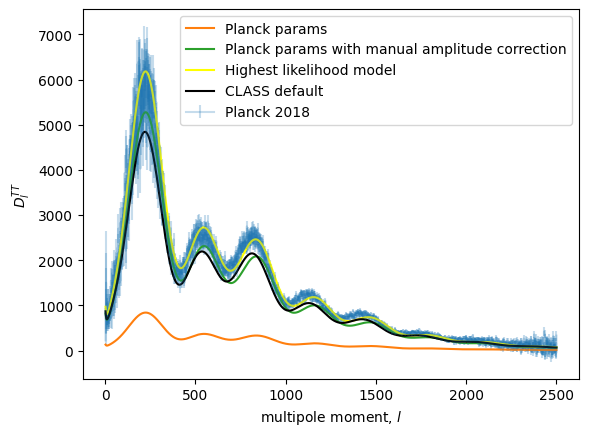

In [189]:
# Check CLASS' solution for the standard set of parameters against the PLANCK data

plt.errorbar(data['l'], data['Dl'], errorbars, label='Planck 2018', alpha=0.25)
theta_cdm = [0.0223828, 0.1201075, 0.67810, 1]

dls = get_Dls(theta_cdm)#*10**12.85# We're probably missing a unit conversion here
plt.plot(ls, dls, label='Planck params')

theta_cdm_amped = [0.0223828, 0.1201075, 0.67810, 2*np.pi]
dls_amped = get_Dls(theta_cdm_amped)# Add an amplitude correction here
plt.plot(ls, dls_amped, label='Planck params with manual amplitude correction')

dls_bf = get_Dls(theta_max)
plt.plot(ls, dls_bf, label='Highest likelihood model', color='yellow', alpha=1.)

plt.plot(ls, dls_default_params, label='CLASS default', color='black', alpha=1.)

plt.xlabel("multipole moment, $l$")
plt.ylabel("$D_l^{TT}$")
plt.legend()

In [237]:
a = ln_prob([0.02220314,0.12199268,0.6839379,7.42369534], data['l'], data['Dl'], data['-dDl'], data['+dDl'])
np.exp(likelihood_max-a)

2.354799742502315e+130

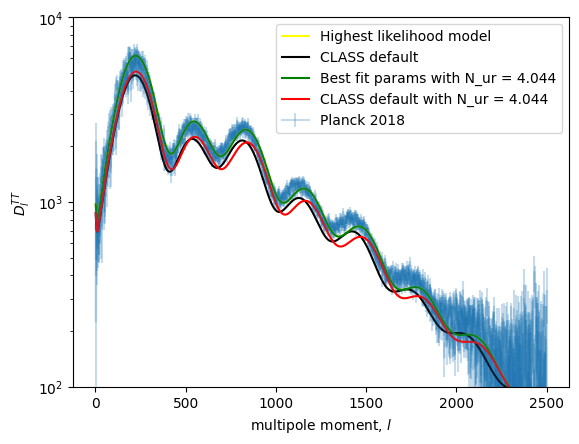

In [233]:
# Check CLASS' solution for the standard set of parameters against the PLANCK data

plt.errorbar(data['l'], data['Dl'], errorbars, label='Planck 2018', alpha=0.25)
#plt.plot(ls, dls_amped, label='Planck params with manual amplitude correction')
plt.plot(ls, dls_bf, label='Highest likelihood model', color='yellow', alpha=1.)
plt.plot(ls, dls_default_params, label='CLASS default', color='black', alpha=1.)

trial = Class()
# trial.set({'output':'tCl, lCl', 'lensing':'yes', 'N_ur':4.044, 'omega_b':0.02220314,'omega_cdm':0.12199268,'h':0.6839379, 'amp': 7.42369534})
# trial.compute()
# ells = trial.lensed_cl(2500)['ell'][2:]
dls_trial = get_Dls([0.02220314,0.12199268,0.6839379,7.42369534])
plt.plot(ells, dls_trial, label='Best fit params with N_ur = 4.044', color='green', alpha=1.)

neff_class = Class()
neff_class.set({'output':'tCl, lCl', 'lensing':'yes', 'N_ur':4.044})
neff_class.compute()
ells = neff_class.lensed_cl(2500)['ell'][2:]
dls_neff = (10**12)*neff_class.lensed_cl(2500)['tt'][2:]*ells*(ells+1)
plt.plot(ells, dls_neff, label='CLASS default with N_ur = 4.044', color='red', alpha=1.) 

plt.xlabel("multipole moment, $l$")
plt.ylabel("$D_l^{TT}$")
plt.yscale('log')
plt.ylim(1e2, 1e4)
plt.legend()

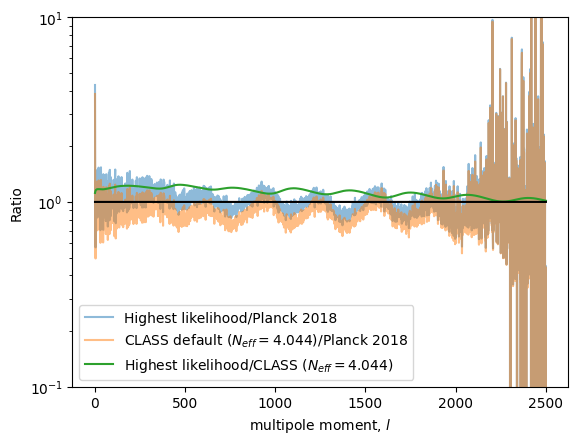

In [215]:
# Check CLASS' solution for the standard set of parameters against the PLANCK data

plt.plot(data['l'], dls_bf/data['Dl'], label='Highest likelihood/Planck 2018', alpha = 0.5)
#plt.plot(ls, dls_amped, label='Planck params with manual amplitude correction')
plt.plot(ls, dls_neff/data['Dl'], label='CLASS default ($N_{eff} = 4.044$)/Planck 2018', alpha = 0.5)
plt.plot(ls, dls_bf/dls_neff, label='Highest likelihood/CLASS ($N_{eff} = 4.044$)')
plt.plot(ls, np.ones(len(ls)), color='black')

plt.xlabel("multipole moment, $l$")
plt.ylabel("Ratio")
plt.yscale('log')
plt.ylim(1e-1, 1e1)
plt.legend()

294.31986015953714
16.738838987521582


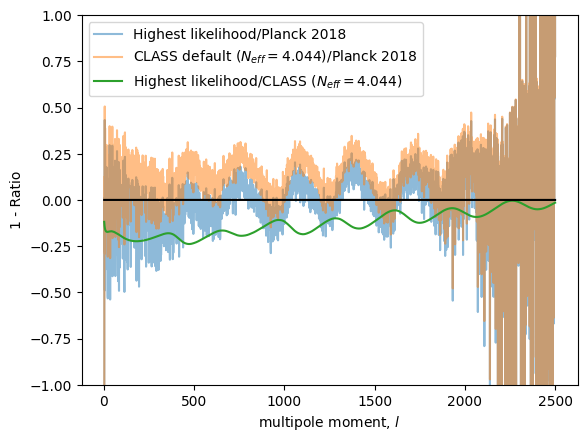

In [221]:
# Check CLASS' solution for the standard set of parameters against the PLANCK data

plt.plot(data['l'], 1- dls_bf/data['Dl'], label='Highest likelihood/Planck 2018', alpha = 0.5)
#plt.plot(ls, dls_amped, label='Planck params with manual amplitude correction')
plt.plot(ls, 1-dls_neff/data['Dl'], label='CLASS default ($N_{eff} = 4.044$)/Planck 2018', alpha = 0.5)
plt.plot(ls, 1- dls_bf/dls_neff, label='Highest likelihood/CLASS ($N_{eff} = 4.044$)')
plt.plot(ls, np.zeros(len(ls)), color='black')

print(np.sum(1-dls_neff/data['Dl']))
print(np.sum(1-dls_bf/data['Dl']))

plt.xlabel("multipole moment, $l$")
plt.ylabel("1 - Ratio")
# plt.yscale('log')
plt.ylim(-1,1)
plt.legend()

In [228]:
planck_likelihood = log_likelihood(dls, data['l'], data['Dl'], data['-dDl'], data['+dDl'], 1)

aic_best_fit = 2*10 - 2*likelihood_max # There are ten parameters in the standard cosmological model, even though we haven't fit them all directly in this analysis
aic_planck = 2*10 - 2*planck_likelihood



relative_likelihood = np.exp((aic_best_fit - aic_planck)/2)

print(f"The relative likelihood of the Planck best-fit to our best-fit is {relative_likelihood}")

print(likelihood_max)


The relative likelihood of the Planck best-fit to our best-fit is 0.0
-480.754269235625


In [229]:
theta_max

array([0.02220314, 0.12199268, 0.6839379 , 7.42369534])